# Data understanding - crimes at SP

## Purpose
Initiate the understanding about the data within the SSP/SP.

## Methodology
EDA

# Setup

## Library import
We import all the required Python libraries

In [18]:
import os
import warnings

import cufflinks as cf
import dtale
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.offline as ply
import plotly.figure_factory as ff
import seaborn as sns

# Options for libraries
cf.go_offline(connected=True)
cf.set_config_file(theme='white')
pd.options.display.max_columns = None
pd.options.display.max_rows = 30
plotly.offline.init_notebook_mode(connected=True)
plt.style.use('seaborn-paper')
warnings.filterwarnings("ignore")

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2
%matplotlib inline

## Local library import
We import all the required local libraries libraries

In [19]:
# Include local library paths
os.chdir('../')
# Wrtite here the local imports.
# from src.utils.example import example
os.chdir('./notebooks/')

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [20]:
# Data folders
RAW_DATA_FOLDER = "../data/raw/"
INTERIM_DATA_FOLDER = "../data/interim/"
PROCESSED_DATA_FOLDER = "../data/processed/"

RANDOM_STATE = 42


# Data import
We retrieve all the required data for the analysis.

In [21]:
df = pd.read_parquet(INTERIM_DATA_FOLDER+'df_consolidado.pqt')

print(f"""df's shape: {df.shape}""")

df.head()

df's shape: (31, 38)


Ocorrencia,ANO,MES,Nº DE ARMAS DE FOGO APREENDIDAS,Nº DE FLAGRANTES LAVRADOS,Nº DE INFRATORES APREENDIDOS EM FLAGRANTE,Nº DE INFRATORES APREENDIDOS POR MANDADO,Nº DE PESSOAS PRESAS EM FLAGRANTE,Nº DE PESSOAS PRESAS POR MANDADO,Nº DE PRISÕES EFETUADAS,Nº DE VEÍCULOS RECUPERADOS,OCORRÊNCIAS DE APREENSÃO DE ENTORPECENTES(1),OCORRÊNCIAS DE PORTE DE ENTORPECENTES,OCORRÊNCIAS DE PORTE ILEGAL DE ARMA,OCORRÊNCIAS DE TRÁFICO DE ENTORPECENTES,TOT. DE INQUÉRITOS POLICIAIS INSTAURADOS,ESTUPRO,ESTUPRO DE VULNERÁVEL,FURTO - OUTROS,FURTO DE VEÍCULO,HOMICÍDIO CULPOSO OUTROS,HOMICÍDIO CULPOSO POR ACIDENTE DE TRÂNSITO,HOMICÍDIO DOLOSO (2),HOMICÍDIO DOLOSO POR ACIDENTE DE TRÂNSITO,LATROCÍNIO,LESÃO CORPORAL CULPOSA - OUTRAS,LESÃO CORPORAL CULPOSA POR ACIDENTE DE TRÂNSITO,LESÃO CORPORAL DOLOSA,LESÃO CORPORAL SEGUIDA DE MORTE,Nº DE VÍTIMAS EM HOMICÍDIO DOLOSO (3),Nº DE VÍTIMAS EM HOMICÍDIO DOLOSO POR ACIDENTE DE TRÂNSITO,Nº DE VÍTIMAS EM LATROCÍNIO,ROUBO - OUTROS,ROUBO A BANCO,ROUBO DE CARGA,ROUBO DE VEÍCULO,TENTATIVA DE HOMICÍDIO,TOTAL DE ESTUPRO (4),TOTAL DE ROUBO - OUTROS (1)
201901,2019,01,242,2190,173,77,2647,1345,2537,1828,34,115,95,556,7471,61,153,17270,2847,3,66,55,0,6,89,1106,2565,2,56,0,6,10672,1,307,1747,71,214,10980
201902,2019,02,224,2230,248,15,2677,1158,2696,1623,33,133,76,632,7993,67,119,19468,2866,4,31,48,0,4,98,988,2495,2,48,0,5,9948,1,257,1585,57,186,10206
201903,2019,03,266,2566,338,20,3016,1080,3107,1909,29,141,113,703,7771,72,166,23693,3031,0,31,75,0,3,97,1170,2662,0,85,0,3,11509,2,299,1796,64,238,11810
201904,2019,04,279,2456,336,38,2996,1301,3072,1954,33,111,108,689,7991,60,169,18730,3274,0,22,59,0,3,172,1255,2793,1,59,0,3,10844,1,296,1865,69,229,11141
201905,2019,05,238,2600,308,21,3064,1300,3199,1905,52,153,92,767,8817,58,141,20480,3450,1,47,45,0,7,104,1285,2429,1,50,0,7,11263,1,283,1914,67,199,11547


# Data processing
Put here the core of the notebook. Feel free di further split this section into subsections.

In [22]:
dct_crime = {
    'ESTUPRO': [crime for crime in df.columns if 'ESTUPRO' in crime],
    'ROUBO': [crime for crime in df.columns if 'ROUBO' in crime],
    'FURTO': [crime for crime in df.columns if 'FURTO' in crime],
    'LESÃO': [crime for crime in df.columns if 'LESÃO' in crime],
    'HOMICÍDIO': [crime for crime in df.columns if 'HOMICÍDIO' in crime]
}

In [25]:
df_crime_consolidado = df[["ANO"]].copy()

for key, value in dct_crime.items():
    df_crime_consolidado[key] = df[value].sum(axis=1)
    
df_crime_consolidado

Ocorrencia,ANO,ESTUPRO,ROUBO,FURTO,LESÃO,HOMICÍDIO
201901,2019,428,23707,20117,3762,251
201902,2019,372,21997,22334,3583,188
201903,2019,476,25416,26724,3929,255
201904,2019,458,24147,22004,4221,209
201905,2019,398,25008,23930,3819,210
...,...,...,...,...,...,...
202103,2021,426,20660,14985,3309,200
202104,2021,368,19723,14587,2819,194
202105,2021,362,21934,17677,3123,186
202106,2021,366,21173,17942,2995,186


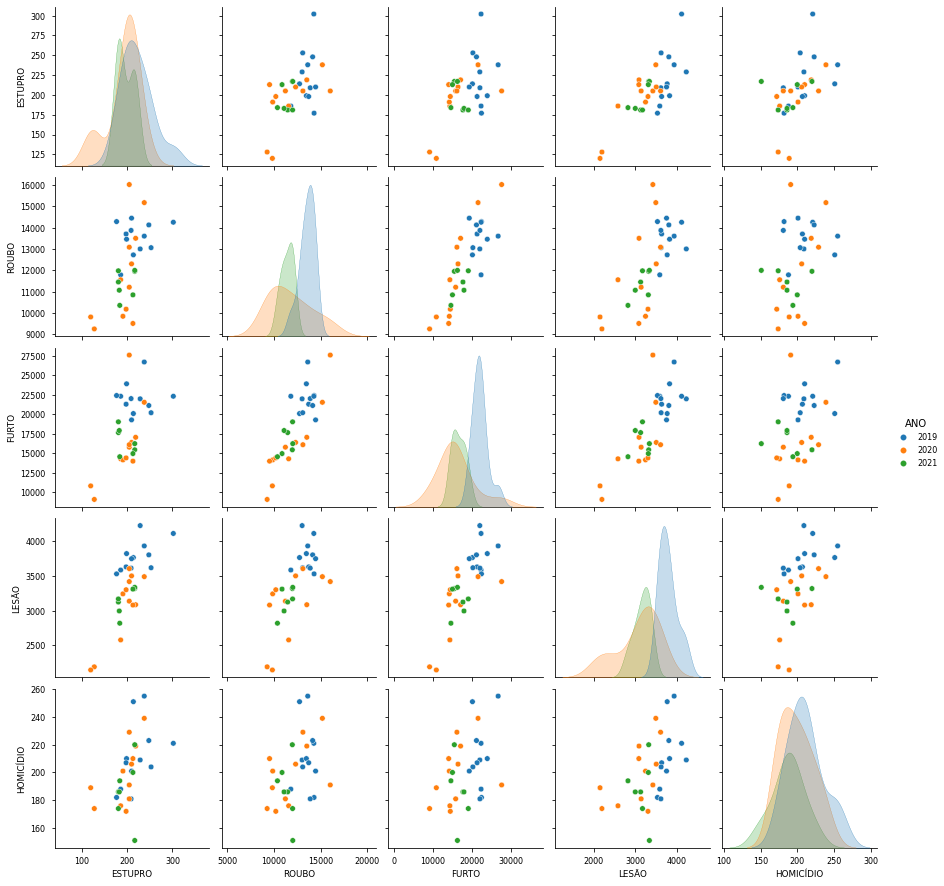

In [10]:
sns.pairplot(df_crime_consolidado, hue='ANO');

In [26]:
fig = ff.create_scatterplotmatrix(df_crime_consolidado, diag='box', index='ANO', height=1000, width=1000)
fig.write_html('../reports/crimes_scatter.html')
fig.show()

# References
We report here relevant references:
1. author1, article1, journal1, year1, url1
2. author2, article2, journal2, year2, url2